In [44]:
import os, sys, re, time, string, unicodedata

import tensorflow as tf
import pickle
import numpy as np
from tensorflow.contrib.learn import DNNClassifier
import time

# Representation
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

#Carga stop word
#nltk.download('stopwords')
spanish_stopwords = nltk.corpus.stopwords.words('spanish')


# texto de prueba
## campo "test_text"

In [45]:
#test_text = 'El Banco Falabella se convertirá en el mayor emisor de tarjetas de crédito del país, después de que la Superintendencia de Bancos e Instituciones Financieras (SBIF) aprobara la integración de CMR Falabella a la compañía. La figura bajo la cual CMR se integra a Banco Falabella es la de Sociedad de Apoyo al Giro (SAG). Con esto, Banco Falabella será el mayor emisor de tarjetas de crédito del país, con una cantidad superior a los 3 millones de ellas activas, según Diario Financiero.'
#test_text = 'Un total de 916 personas murieron en acciones que involucraron a la policía y otras 2.989 fallecieron en homicidios dolosos, durante los ochos meses de intervención de la seguridad pública en Río de Janeiro, la ciudad más emblemática de Brasil, según informe divulgado este lunes por una ONG.Las muertes de miembros de la Policía y el Ejército durante el período en que ha sido implementada la intervención, también fueron retomadas en el informe, según el cual 74 agentes han fallecido entre febrero y octubre de 2018."Las políticas de guerra contra las drogas y los enfrentamientos como método de seguridad pública son responsables por los inaceptables números de Río de janeiro: además de las muertes de civiles y militares, casi mil muertes de civiles por acción policial", aseguró el informe de la ONG.Los datos se recogen en un informe divulgado este martes por el Observatorio de la Intervención del Centro de Estudios de Seguridad y Ciudadanía de la Universidad brasileña Cándido Mendes, a través de las redes sociales.'
test_text = "Los vecinos del Parque O'Higgins podrán decidir cómo se invertirán los dineros obtenidos por los derechos municipales pagados por la Fórmula E, que realizará allí una fecha de su competencia en enero próximo."

### funciones y clases "template"

Para normalizar y clasficador , calcular features TFIDF+SVD,  DNN para evular

In [46]:

def normalize_text(text):
    """ Funcion de normalizacion """    
    # split into words
    tokens = nltk.tokenize.word_tokenize(text,language='spanish', preserve_line=False)
    # convert to lower case
    tokens = [w.lower() for w in tokens]    
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are n<<<<<<<<<<<<<<<<<<<<<
    words = [word for word in stripped if word.isalpha()]
    
    # stop word and remove accent
    def strip_accents(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    stop_words = set(spanish_stopwords)
    words = [strip_accents(w) for w in words if not w in stop_words]
#    return u" ".join(words)
    
    stemmer = SnowballStemmer("spanish")
    out = ""
    for word in words:
        out += stemmer.stem(word)+" "    
    return out

In [47]:
class tfidf_svd:
    def __init__(self, wordbach_trained , svd_trained,non_zero_index_feat,normalize_text):
        """ extractor features"""
        self.wordbach = wordbach_trained
        self.svdT = svd_trained
        self.non_zero_index_feat = non_zero_index_feat
        self.normalize_text = normalize_text
    
    def calc(self,text):
        
        self.tfidf = self.wordbach.transform([self.normalize_text(text)])
        self.tfidf = self.tfidf[:, self.non_zero_index_feat]
        tfidf_svd = self.svdT.transform(self.tfidf)
        return(tfidf_svd)

In [48]:
class DNN_eval:
    def __init__(self, labels, path_model,dim_vec_input):
        """ DNN eval"""
        self.path_model = path_model
        self.labels = labels
        
        self.nClasses = len(self.labels)
        self.feature_columns = [tf.contrib.layers.real_valued_column('x', dimension = dim_vec_input)]
        self.classifier = DNNClassifier(                                
                                   n_classes=len(labels), label_keys=self.labels, 
                                   feature_columns=self.feature_columns,
                                   hidden_units=[2000], 
                                   model_dir = self.path_model                         
                                  )
    def input_fn_evaluate(self):
        input = {'x': tf.constant(self.vec_input )}    
        return input    

    def calc(self,vec_input):
        self.vec_input = vec_input
        #pred_test = self.classifier.predict_classes(input_fn=self.input_fn_evaluate)
        pred_prob = self.classifier.predict_proba(input_fn=self.input_fn_evaluate)
        pred_prob = [x for x in list(pred_prob)]
        y_test_hat = self.labels[np.argmax(pred_prob)]
        #y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
        #y_test_hat = y_test_hat.astype(str)
        return (y_test_hat , pred_prob[0])
    

In [49]:
root_path = "../../"

file_name = "tfid_hash28_n10000_svd1000.p"
features_path = root_path + 'data/features/'
features_path_ = features_path + "calcFeat_" + file_name
path_model = root_path + 'models/test/'
path_model_tema = root_path + 'models/seccion/'



### carga info modelos

In [50]:
labels_tema_all = pickle.load( open( path_model_tema+ "info_model.p", "rb" ) )[1]
labels = pickle.load( open( path_model + "info_model.p", "rb" ) )[1]

### carga clase extractor features TFIDF+SVF

In [51]:
wb,svdT,non_zero_index_feat = pickle.load( open( features_path_, "rb" ) )

tfidf_svd_model = tfidf_svd(wb,svdT,non_zero_index_feat,normalize_text)  

### carga modelo DNN seccion

In [52]:
sec1 = DNN_eval(labels, path_model,1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdc346e67f0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../../models/test/'}


### evalua una entrada de test 

In [53]:
start = time.time()
feat_vec = tfidf_svd_model.calc(test_text)
y_test_hat , pred_prob = sec1.calc( vec_input = feat_vec)

y_test_hat

Normalize text
Extract wordbags
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../../models/test/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


'deportes'

### clasificador de tema

carga modelo a partir de seccion predicha

In [54]:

path_model_tema_ = path_model_tema + "/" + y_test_hat
labels_tema = labels_tema_all[y_test_hat]
tema1 = DNN_eval(labels_tema, path_model_tema_,1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdc354eb588>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../../models/seccion//deportes'}


In [55]:
start = time.time()
y_test_hat_tema , pred_prob_tema = tema1.calc( vec_input = feat_vec)

print("end time :" + str(time.time() - start) )
y_test_hat_tema

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../../models/seccion//deportes/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
end time :0.17212653160095215


'rally'

### plot

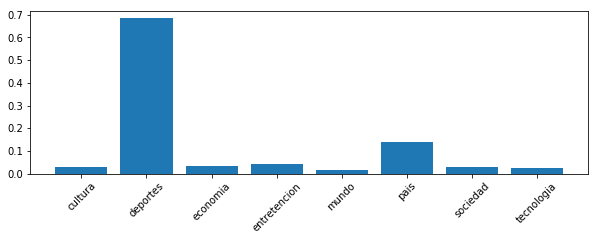

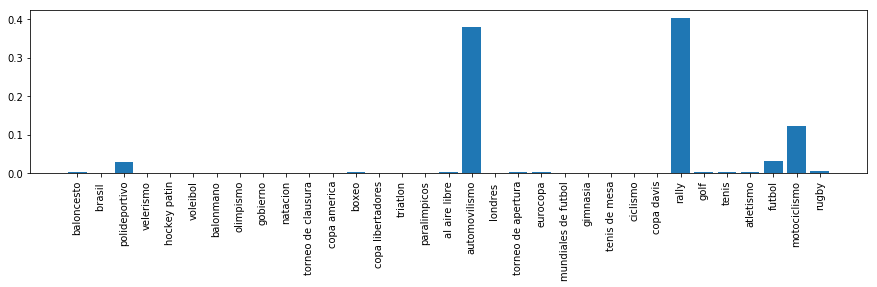

<Figure size 2880x2880 with 0 Axes>

seccion : deportes
tema: rally

Los vecinos del Parque O'Higgins podrán decidir cómo se invertirán los dineros obtenidos por los derechos municipales pagados por la Fórmula E, que realizará allí una fecha de su competencia en enero próximo.


In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.bar(np.arange(8), pred_prob)
plt.xticks(np.arange(8), labels)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15,3))
plt.bar(np.arange(len(labels_tema)), pred_prob_tema)
plt.xticks(np.arange(len(labels_tema)), labels_tema)
plt.xticks(rotation=90)
plt.figure(figsize=(40,40))
plt.show()

print( "seccion : " +y_test_hat+ "\ntema: "+y_test_hat_tema + "\n")
print(test_text)

In [57]:
pred_prob

array([0.02808294, 0.68385124, 0.03181024, 0.04433168, 0.01722042,
       0.13866127, 0.02931813, 0.02672421], dtype=float32)